# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

target = df['salary_in_usd']
df = df.drop(['salary', 'salary_in_usd'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=23)

X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=23)

Лик в данных возможен из-за salary, поэтому я его удалила.

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


categorical_features = list(X_train_train.columns[(X_train_train.dtypes == 'object').values])

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train_train[categorical_features])
X_train_train_ohe = ohe.transform(X_train_train[categorical_features])
X_train_train_ohe = pd.DataFrame(X_train_train_ohe, columns = ohe.get_feature_names_out())
X_train_full = pd.concat([X_train_train_ohe, X_train_train[['work_year', 'remote_ratio']].reset_index()], axis=1)

X_valid_ohe = ohe.transform(X_valid[categorical_features])
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=ohe.get_feature_names_out())
X_valid_full = pd.concat([X_valid_ohe, X_valid[['work_year', 'remote_ratio']].reset_index()], axis=1)

X_test_ohe = ohe.transform(X_test[categorical_features])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out())
X_test_full = pd.concat([X_test_ohe, X_test[['work_year', 'remote_ratio']].reset_index()], axis=1)


lr = LinearRegression()
lr.fit(X_train_full, y_train_train)
y_pred = lr.predict(X_test_full)

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared = False))

MAPE:  257158.03265948436
RMSE:  68568576664.663246


Ну оооооочень огромные ошибки!

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [3, 6, 9, 12, 15],
    'gamma': [0.01, 0.1, 1, 5, 10],
    'subsample': [0.05, 0.1, 0.5, 0.75, 1]
}

from sklearn.model_selection import GridSearchCV

model_xgb = XGBRegressor(seed=1)

grid_search = GridSearchCV(estimator=model_xgb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_valid_full, y_valid)
grid_search.best_params_, grid_search.best_score_

({'gamma': 0.01,
  'learning_rate': 0.2,
  'max_depth': 6,
  'n_estimators': 15,
  'subsample': 0.5},
 -2137506964.7096877)

Лучшими оказались значения:
'gamma': 0.01,
'learning_rate': 0.2,
'max_depth': 6,
'n_estimators': 15,
'subsample': 0.5.
Давайте чуть уточним предсказание:

In [ ]:
params = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.15, 0.2, 0.25],
    'n_estimators': [13, 15, 17],
    'gamma': [0.001, 0.01, 0.03],
    'subsample': [0.4, 0.5, 0.6]
}


model_xgb = XGBRegressor(seed=1)

grid_search = GridSearchCV(estimator=model_xgb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_valid_full, y_valid)
grid_search.best_params_, grid_search.best_score_

({'gamma': 0.001,
  'learning_rate': 0.2,
  'max_depth': 6,
  'n_estimators': 15,
  'subsample': 0.5},
 -2137506964.7096877)

In [ ]:
import time
start_time = time.time()

XGB = XGBRegressor(seed=1, gamma=0.001, learning_rate=0.2, max_depth=6, n_estimators=15, subsample=0.5)
XGB.fit(X_train_full, y_train_train)
end_time_tr = time.time()

y_pred_XGB = XGB.predict(X_test_full)
end_time_pr = time.time()

tr_time = end_time_tr - start_time
pred_time = end_time_pr - end_time_tr

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_XGB))
print('RMSE: ', mean_squared_error(y_test, y_pred_XGB, squared = False))
print(f"Скорость обучения: {tr_time:.4f}, скорость предсказания: {pred_time:.4f}")

MAPE:  0.41623061218281915
RMSE:  48596.53390160235
Скорость обучения: 0.6068, скорость предсказания: 0.0609


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

params = {
    'depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'iterations': [25, 50, 75, 100],
    'l2_leaf_reg': [1, 2, 3, 5, 7]
}

CBR = CatBoostRegressor(random_seed=1)

grid_search = GridSearchCV(estimator=CBR, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score="raise")

grid_search.fit(X_valid_full, y_valid)
grid_search.best_params_, grid_search.best_score_

0:	learn: 57446.7746972	total: 1.2ms	remaining: 58.8ms
1:	learn: 54237.6673412	total: 3.01ms	remaining: 72.3ms
2:	learn: 52239.8579281	total: 3.79ms	remaining: 59.3ms
3:	learn: 51212.2979494	total: 5.74ms	remaining: 66.1ms
4:	learn: 49869.3105801	total: 7.71ms	remaining: 69.4ms
5:	learn: 48803.4820019	total: 9.5ms	remaining: 69.7ms
6:	learn: 47970.7010467	total: 11.2ms	remaining: 68.8ms
7:	learn: 47502.6870280	total: 12.8ms	remaining: 67.4ms
8:	learn: 46901.5173978	total: 14.4ms	remaining: 65.8ms
9:	learn: 46406.0114156	total: 16ms	remaining: 63.9ms
10:	learn: 46208.1405049	total: 17.4ms	remaining: 61.9ms
11:	learn: 45880.1230725	total: 19.2ms	remaining: 60.7ms
12:	learn: 45797.7271562	total: 19.7ms	remaining: 56.2ms
13:	learn: 45649.6373960	total: 22.5ms	remaining: 57.9ms
14:	learn: 45466.7967725	total: 23.3ms	remaining: 54.4ms
15:	learn: 45239.4767643	total: 24.1ms	remaining: 51.1ms
16:	learn: 45029.7735824	total: 24.8ms	remaining: 48.1ms
17:	learn: 44709.1890177	total: 25.6ms	remain

({'depth': 4, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.2},
 -2181476538.9007845)

In [ ]:
start_time = time.time()

CBRR = CatBoostRegressor(random_seed=1, depth= 4, iterations= 50, l2_leaf_reg=2, learning_rate =0.2)
CBRR.fit(X_train_full, y_train_train)
end_time_tr = time.time()

y_pred_CBR = CBRR.predict(X_test_full)
end_time_pr = time.time()

tr_time = end_time_tr - start_time
pred_time = end_time_pr - end_time_tr

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_CBR))
print('RMSE: ', mean_squared_error(y_test, y_pred_CBR, squared = False))
print(f"Скорость обучения: {tr_time:.4f}, скорость предсказания: {pred_time:.4f}")

0:	learn: 59383.1706479	total: 3.16ms	remaining: 155ms
1:	learn: 56920.8195830	total: 4.61ms	remaining: 111ms
2:	learn: 55555.2168907	total: 10.1ms	remaining: 158ms
3:	learn: 54053.7100553	total: 14ms	remaining: 161ms
4:	learn: 52781.1098282	total: 17.2ms	remaining: 155ms
5:	learn: 51886.2813175	total: 19.5ms	remaining: 143ms
6:	learn: 51414.5572257	total: 22.2ms	remaining: 136ms
7:	learn: 50974.1083107	total: 26.3ms	remaining: 138ms
8:	learn: 50687.4042959	total: 30.3ms	remaining: 138ms
9:	learn: 50306.5213559	total: 33.8ms	remaining: 135ms
10:	learn: 50158.8200163	total: 38.5ms	remaining: 137ms
11:	learn: 50002.7016398	total: 41.8ms	remaining: 132ms
12:	learn: 49729.2783026	total: 46.9ms	remaining: 133ms
13:	learn: 49614.7992595	total: 49.5ms	remaining: 127ms
14:	learn: 49461.7599888	total: 55.2ms	remaining: 129ms
15:	learn: 49363.4812833	total: 58.1ms	remaining: 123ms
16:	learn: 49212.3753820	total: 61.3ms	remaining: 119ms
17:	learn: 49112.8543761	total: 64.1ms	remaining: 114ms
18:	

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool
from catboost import CatBoostRegressor

catt = X_valid.columns[X_valid.dtypes == 'object'].tolist()

params = {
    'depth': [2, 4, 6],
    'learning_rate': [0.1, 0.2, 0.3],
    'iterations': [25, 50, 75],
    'l2_leaf_reg': [1, 2, 3]
}

train_pool = Pool(data=X_valid, label=y_valid, cat_features=catt)

CBR = CatBoostRegressor(random_seed=1)

grid_search = GridSearchCV(estimator=CBR, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score="raise")

grid_search.fit(X_valid, y_valid, cat_features=catt)
grid_search.best_params_, grid_search.best_score_

0:	learn: 58803.2048936	total: 2.54ms	remaining: 188ms
1:	learn: 57287.1114296	total: 5.3ms	remaining: 194ms
2:	learn: 55964.0278163	total: 7.99ms	remaining: 192ms
3:	learn: 54864.0843590	total: 9.48ms	remaining: 168ms
4:	learn: 53941.2624424	total: 10.9ms	remaining: 153ms
5:	learn: 53061.4717305	total: 12.1ms	remaining: 139ms
6:	learn: 52307.9838085	total: 13.8ms	remaining: 134ms
7:	learn: 51572.3859503	total: 16.3ms	remaining: 137ms
8:	learn: 51156.8310234	total: 17.1ms	remaining: 125ms
9:	learn: 50601.1731315	total: 18.1ms	remaining: 117ms
10:	learn: 50144.3437796	total: 19.8ms	remaining: 115ms
11:	learn: 49773.0063041	total: 21.4ms	remaining: 112ms
12:	learn: 49286.7841541	total: 22.6ms	remaining: 108ms
13:	learn: 48701.0169093	total: 24.3ms	remaining: 106ms
14:	learn: 48257.3058818	total: 26.3ms	remaining: 105ms
15:	learn: 47941.0296236	total: 28.5ms	remaining: 105ms
16:	learn: 47622.5983353	total: 29.8ms	remaining: 102ms
17:	learn: 47495.4144716	total: 31.6ms	remaining: 100ms
18:

({'depth': 4, 'iterations': 75, 'l2_leaf_reg': 2, 'learning_rate': 0.1},
 -2170821230.024236)

In [ ]:
start_time = time.time()

CBRRR = CatBoostRegressor(random_seed=1, depth=4, iterations=75, l2_leaf_reg=2, learning_rate=0.1)
CBRRR.fit(X_train_full, y_train_train)
end_time_tr = time.time()

y_pred_CBRR = CBRRR.predict(X_test_full)
end_time_pr = time.time()

tr_time = end_time_tr - start_time
pred_time = end_time_pr - end_time_tr

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_CBRR))
print('RMSE: ', mean_squared_error(y_test, y_pred_CBRR, squared = False))
print(f"Скорость обучения: {tr_time:.4f}, скорость предсказания: {pred_time:.4f}")

0:	learn: 61401.9087731	total: 1.87ms	remaining: 138ms
1:	learn: 59887.6278370	total: 10.2ms	remaining: 372ms
2:	learn: 58474.7929379	total: 12.1ms	remaining: 291ms
3:	learn: 57223.1493951	total: 13.5ms	remaining: 239ms
4:	learn: 56082.4914001	total: 14.5ms	remaining: 203ms
5:	learn: 55153.8806283	total: 15.6ms	remaining: 179ms
6:	learn: 54490.8632263	total: 16.8ms	remaining: 164ms
7:	learn: 53832.1261885	total: 17.8ms	remaining: 149ms
8:	learn: 53353.2770539	total: 19.1ms	remaining: 140ms
9:	learn: 52854.2925229	total: 20.1ms	remaining: 131ms
10:	learn: 52512.5122947	total: 21.4ms	remaining: 124ms
11:	learn: 52200.0147992	total: 22.4ms	remaining: 118ms
12:	learn: 51844.0732998	total: 23.4ms	remaining: 112ms
13:	learn: 51549.6726802	total: 24.7ms	remaining: 108ms
14:	learn: 51347.3734751	total: 25.7ms	remaining: 103ms
15:	learn: 51185.9309688	total: 27ms	remaining: 99.5ms
16:	learn: 50948.1926787	total: 28ms	remaining: 95.5ms
17:	learn: 50829.1175728	total: 29.2ms	remaining: 92.6ms
18:

**Ответ:** качество модели стало хуже, ошибка увеличилась :(

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
#!arch -arm64 brew install libomp

arch: invalid option -- 'a'
Try 'arch --help' for more information.


In [ ]:
from lightgbm import LGBMRegressor

params = {
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 75, 100],
    'num_leaves': [5, 10, 20]
}

GBM = LGBMRegressor(random_seed=1)

grid_search = GridSearchCV(estimator=GBM, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score="raise")

grid_search.fit(X_valid_full, y_valid)
grid_search.best_params_, grid_search.best_score_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 676, number of used features: 22
[LightGBM] [Info] Start training from score 136780.612426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

({'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 10},
 -2201226154.35326)

In [ ]:
start_time = time.time()

GBMM = LGBMRegressor(random_seed=1, learning_rate=0.05, max_depth=4, n_estimators=50, num_leaves=10)
GBMM.fit(X_train_full, y_train_train)
end_time_tr = time.time()

y_pred_GBM = GBMM.predict(X_test_full)
end_time_pr = time.time()

tr_time = end_time_tr - start_time
pred_time = end_time_pr - end_time_tr

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_GBM))
print('RMSE: ', mean_squared_error(y_test, y_pred_GBM, squared = False))
print(f"Скорость обучения: {tr_time:.4f}, скорость предсказания: {pred_time:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 2703, number of used features: 42
[LightGBM] [Info] Start training from score 137737.302997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAPE:  0.45016519817489853
RMSE:  49292.54118001279
Скорость обучения: 0.0758, скорость предсказания: 0.0053


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

XGBoost ('gamma': 0.001, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 15, 'subsample': 0.5)

---

*   MAPE:  0.41623061218281915
*   RMSE:  48596.53390160235
*   Скорость обучения: 0.6068
*   Cкорость предсказания: 0.0609








CatBoost 1 ('depth': 4, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.2)

---
*   MAPE:  0.4150361031071456
*   RMSE:  49193.863441648486
*   Скорость обучения: 0.3205
*   Cкорость предсказания: 0.0196

CatBoost 2 ('depth': 4, 'iterations': 75, 'l2_leaf_reg': 2, 'learning_rate': 0.1)


---

* MAPE:  0.4280114112646153
* RMSE:  49597.94725584346
* Скорость обучения: 0.2164
* Скорость предсказания: 0.0226

LightGBM ('learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50, 'num_leaves': 10)

---
* MAPE:  0.45016519817489853
* RMSE:  49292.54118001279
* Скорость обучения: 0.0758
* Cкорость предсказания: 0.0053


**Ответ:** самая низкая MAPE и RMSE у CatBoost 1, но скорость обучения и предсказания значительно ниже у LightGBM, в то время как у CatBoost 1 оно примерно в 4 раза больше, но не самое большое среди этих всех моделей. Опираясь на меньшуюю ошибку, лучшая модель - CatBoost 1. Худшая модель, опираясь на MAPE - LightGBM. По скорости обучения и предсказания лучшая модель - LightGBM, худшая - XGBoost. Видим, что каждая модель дала разные оптимальные значения параметров, но learning_rate=0.2 у 1-ой и 2-ой модели и также глубина дерева равна 4 у последних трех моделей.


# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
import numpy as np
tr_ratings = ratings.transpose()
tr_ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [ ]:
rratings = tr_ratings.drop('user')
rratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
ratings = rratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the rocket summer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(ratings)
labels = pd.DataFrame(kmeans.labels_)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
labels.value_counts()

1    996
0      1
2      1
3      1
4      1
Name: count, dtype: int64

**Ответ:** получилось, что большинство объектов вошли в 1 класс, то есть классы получились несбалансированными, значит, кластеризация получилась неполезной. Возможно, наши данные имеют необычную форму распределения, поэтому kmeans не может нормально классифицировать объекты. Но далее мы понимаем, что данные не нормализованы, поэтому такой дисбаланс.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
for i in range(len(labels)):
  if labels.iloc[i][0] != 1:
    print(ratings.index[i])

the beatles
pink fluid
niИ
bone: thugs~n~harmony


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
dict1={}
dict2={}
for i in range(len(labels)):
  if labels[0][i] != 1:
    table = pd.DataFrame(ratings.loc[ratings.index[i]].value_counts())
    sum2 = ratings.loc[ratings.index[i]].sum()
    sum1 = 0
    for j in table.index:
      if j != 0:
        sum1 += int(table['count'][j])
    dict1[ratings.index[i]] = sum1/5000
    dict2[ratings.index[i]] = round(sum2/5000, 5)

print('Доли пользователей:', dict1)
print('Средние доли прослушивания:', dict2)

Доли пользователей: {'the beatles': 0.3342, 'pink fluid': 0.1256, 'niИ': 0.1182, 'bone: thugs~n~harmony': 0.0144}
Средние доли прослушивания: {'the beatles': 0.01837, 'pink fluid': 0.00491, 'niИ': 0.00647, 'bone: thugs~n~harmony': 0.00079}


**Ответ:** The Beatles имеет большее число слушателей и соответсвенно большую долю прослушивания. Ну, The Beatles - это база.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize
norm_ratings = pd.DataFrame(normalize(ratings))

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
kmeans2 = KMeans(n_clusters=5, random_state=1)
kmeans2.fit(norm_ratings)
norm_labels = pd.DataFrame(kmeans2.labels_)
norm_labels.value_counts()

2    279
1    269
4    228
0    123
3    101
Name: count, dtype: int64

**Ответ:** стало лучше, данных достаточно в каждом кластере, поэтому теперь кластеризация полезна. Возможно, они не супер-пупер сбалансированы, но лучше так, чем никак.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine

centroids = kmeans2.cluster_centers_

df_centroids = pd.DataFrame(centroids, columns=norm_ratings.columns)

dict3 = {}

for i in range(len(centroids)):
    dist = norm_ratings.apply(lambda row: cosine(row, centroids[i]), axis=1)
    close_art = dist.nsmallest(10).index
    dict3[i] = close_art.tolist()

for i, art in dict3.items():
  print('')
  print(f'Топ-10 исполнителей в кластере {i+1}:')
  for j in art:
    print(ratings.index[j])


Топ-10 исполнителей в кластере 1:
brand new
fall out boy
blink-182
taking back sunday
new found glory
saosin
chiodos
underoath
cartel
all time low

Топ-10 исполнителей в кластере 2:
metallica
‌linkin park
nickelback
acdc
evanescense
kelly clarkson
system of a down
led zeppelin.
maroon5
koЯn

Топ-10 исполнителей в кластере 3:
velvet underground
sonic youth
the pixies
radiohead
the beatles
dylan. bob
the clash
the smiths
oy division
animal collective

Топ-10 исполнителей в кластере 4:
nas
jay-z
kanye west
a tribe called quest
the roots featuring d'angelo
lupe the gorilla
mos def
little brother
gangstarr
lil' wayne

Топ-10 исполнителей в кластере 5:
radiohead
the shins
sufjan stevens
the arcade fire
deathcab for cutie
broken social scene
belle and sebastian
spoon
ironand wine
beirut


**Ответ:** кластеры были разделены по основному жанру музыки исполнителей. 1 кластер - панк-рок, 2 кластер - метал (хард-рок), 3 кластер - альтернативный рок, 4 кластер - хип-хоп, 5 кластер - инди-рок.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

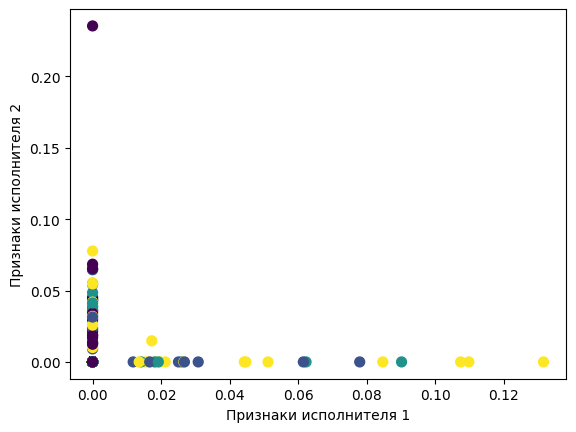

In [ ]:
import matplotlib.pyplot as plt
normik = normalize(ratings)
plt.scatter(normik[:, 1], normik[:, 100], c=norm_labels, s=50)
plt.xlabel('Признаки исполнителя 1')
plt.ylabel('Признаки исполнителя 2');

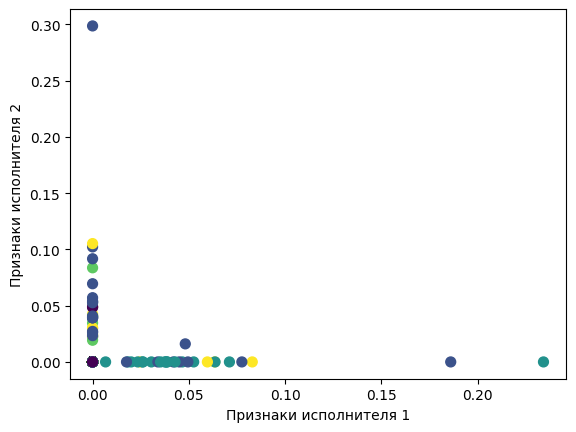

In [ ]:
plt.scatter(normik[:, 50], normik[:, 500], c=norm_labels, s=50)
plt.xlabel('Признаки исполнителя 1')
plt.ylabel('Признаки исполнителя 2');

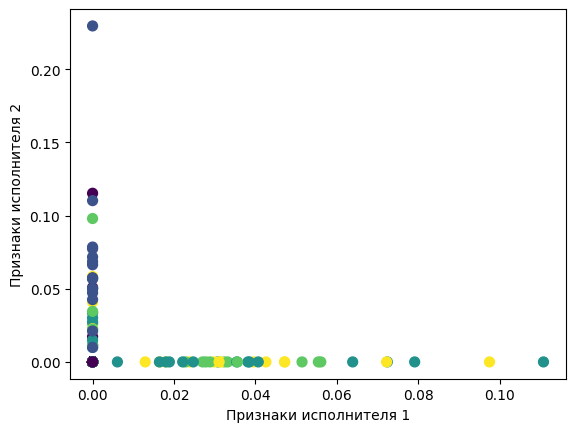

In [ ]:
plt.scatter(normik[:, 25], normik[:, 1000], c=norm_labels, s=50)
plt.xlabel('Признаки исполнителя 1')
plt.ylabel('Признаки исполнителя 2');

**Ответ:** видим, что признаки распределены по краям графиков, то есть между признаками разных исполнителей не наблюдается линейная зависимость. Разделение на кластеры плохо отражено, потому что наблюдения накладываются друг на друга.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

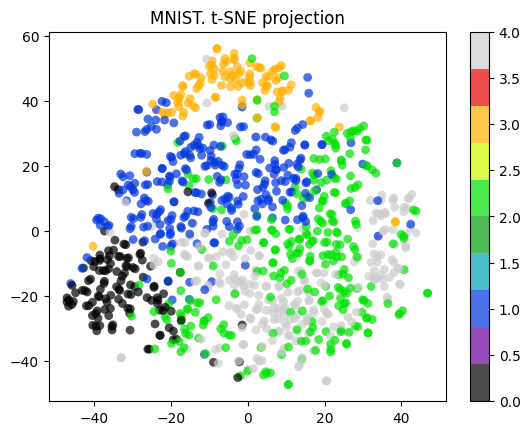

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1)
X_tsne = tsne.fit_transform(norm_ratings) # две координаты

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=norm_labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

На графике отчетливо видим 5 кластеров.

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score


n = list(range(50, 100, 8))
n.append(62)
n.append(99)
n.append(100)
for cluster in n:
    kmeans = KMeans(n_clusters = cluster, random_state=42)
    kmeans = kmeans.fit(norm_ratings)
    clusters = kmeans.predict(norm_ratings)

    print(f"n={cluster} and score={silhouette_score(norm_ratings, clusters):.4f}")

n=50 and score=0.0078
n=58 and score=0.0097
n=66 and score=0.0086
n=74 and score=0.0102
n=82 and score=0.0118
n=90 and score=0.0127
n=98 and score=0.0141
n=62 and score=0.0104
n=99 and score=0.0145
n=100 and score=0.0153


Оптимальное число кластеров - 100.

In [ ]:
kmeans3 = KMeans(n_clusters = 100, random_state=42)
kmeans3.fit(norm_ratings)
km_labels = kmeans3.labels_

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
centroids = kmeans3.cluster_centers_

df_centroids = pd.DataFrame(centroids, columns=norm_ratings.columns)

dict4 = {}

for i in range(len(centroids)):
    dist = norm_ratings.apply(lambda row: cosine(row, centroids[i]), axis=1)
    close_art = dist.nsmallest(10).index
    dict4[i] = close_art.tolist()

for i, art in dict4.items():
  print('')
  print(f'Топ-10 исполнителей в кластере {i+1}:')
  for j in art:
    print(ratings.index[j])


Топ-10 исполнителей в кластере 1:
louıs armstrong
Ｂille holiday
ray charles
the band
duke ellington
nina simone
reinhardt, django
buddy holly
ella fitzgerald
miles davis.

Топ-10 исполнителей в кластере 2:
aphex twin
boards of canada
autechre
squarepusher.
stars of the lid
amon tobin
eluvium
air
four tet
eno

Топ-10 исполнителей в кластере 3:
wilco
yo la tengo
okkervil river
m. ward
the flaming lips
nick drake
wolf parade
sun kil moon
m.i.a.*
the walkmen

Топ-10 исполнителей в кластере 4:
civilian
stone temple pilots
foo fighters
soundgarden
incubus
red hot clili peppers
alice in chains
the smashing pumpkins
matchbox twenty
311

Топ-10 исполнителей в кластере 5:
a tribe called quest
de la soul
the roots featuring d'angelo
gangstarr
nas
del the funky homosapien
murs and 9th wonder
little brother
people under the staris
common

Топ-10 исполнителей в кластере 6:
mary j. blige
aaliyah
john legend
missy elliott
ne-yo
alanis morrisette
sade
franklin aretha
destinys child
janet jackson.

Топ

**Ответ:** кластеров стало в 20 раз больше, поэтому анализировать будет трудно. Но я обратила внимание на кластер 13, так как там много популярных исполнителей известных и нам, например, beyoncé, lady gaga, rihanna & jay-z, brritney spears. Не трудно догадаться, что все они - исполнители в разных жанрах, поэтому, скорее всего, здесь принцип кластеризации отличается от задания 5. Анализируя множество кластеров, мне и так не удалось понять явный признак, потому что в каждом кластере исполнители из разных стран, жанров и где-то группа, где-то дуэт, где-то один человек. Но есть догадка, что возможно они классифицированы по уровню популярности среди слушателей.

---

Хотя, кластер 13 можно отнести к поп-исполнителям и одновременно популярным. В общем, классификация была по жанрам и популярности одновременно :)

Сделайте t-SNE визуализацию полученной кластеризации.

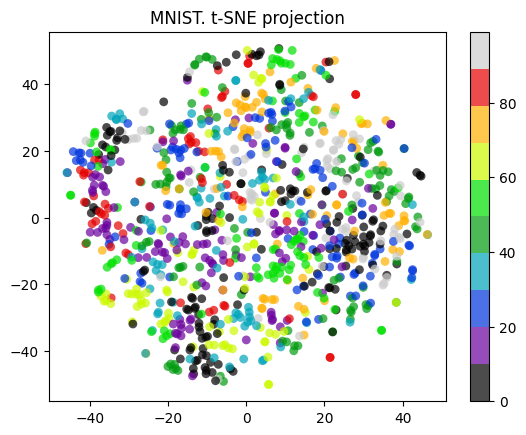

In [ ]:
tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(norm_ratings)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

Из-за большого числа кластеров визуализация - тихий ужас.

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

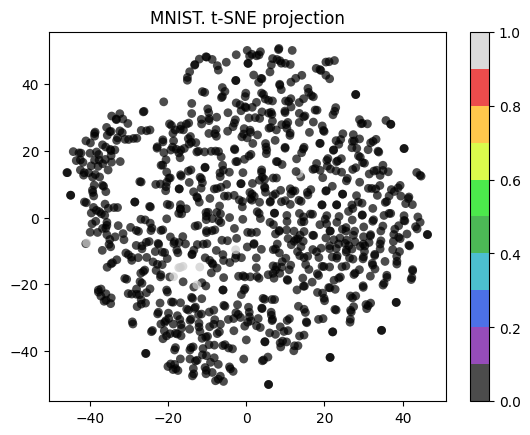

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=(km_labels==49),
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

**Ответ:** может быть я чего-то не понимаю, но любой кластер окрашивается только в черный цвет и не выделяется нормально один из множества кластеров, то есть в данной визуализации один кластер плохо отражается :(